In [28]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file

In [16]:
data = pd.read_csv('intern_task.csv')

In [17]:
data.columns

Index(['rank', 'query_id', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7',
       ...
       'feature_134', 'feature_135', 'feature_136', 'feature_137',
       'feature_138', 'feature_139', 'feature_140', 'feature_141',
       'feature_142', 'feature_143'],
      dtype='object', length=146)

In [18]:
ranks = data['rank'].unique().tolist()
ranks

[0, 1, 2, 4, 3]

In [19]:
query = data['query_id'].unique().tolist()
len(query)

2000

In [20]:
data.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


In [21]:
data.isna().sum().any()

False

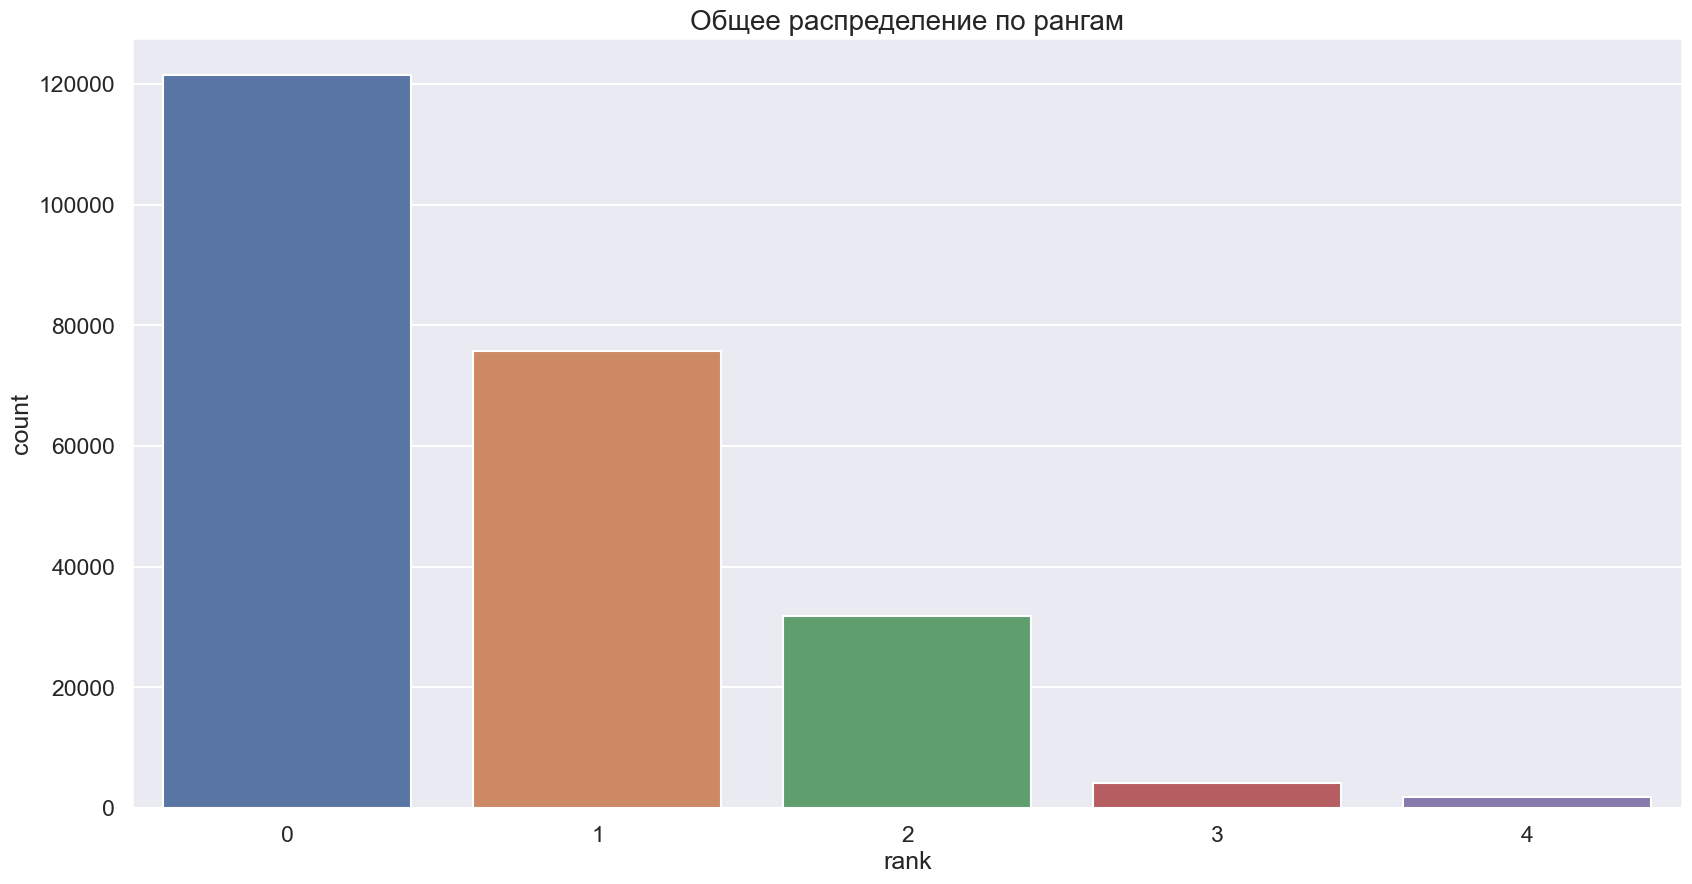

In [22]:
sns.set(style='darkgrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x='rank', 
            data=data, ax=ax);
plt.title('Общее распределение по рангам', fontsize=20);
plt.show()

In [26]:
df_train, df_test = train_test_split(data, test_size=0.33, random_state=324)

## convert dataframe to libsvm txt  format file

In [30]:
def df_to_libsvm_train(df: pd.DataFrame):
    x = data.drop(columns = ['rank','query_id'], axis=1)
    y = data['rank']
    query_id  = data['query_id']
    dump_svmlight_file(X=x, y=y, query_id= query_id, f='train.txt', zero_based=True)
def df_to_libsvm_test(df: pd.DataFrame):
    x = data.drop(columns = ['rank','query_id'], axis=1)
    y = data['rank']
    query_id  = data['query_id']
    dump_svmlight_file(X=x, y=y, query_id= query_id, f='test.txt', zero_based=True)
    
df_to_libsvm_train(df_train)
df_to_libsvm_test(df_test)

# XGBRanking listwise:ndcg 

In [31]:
train = xgb.DMatrix("train.txt")
test = xgb.DMatrix("test.txt")

[19:59:11] 235258x144 matrix with 21264386 entries loaded from train.txt
[19:59:12] 235258x144 matrix with 21264386 entries loaded from test.txt


In [32]:

params = {
    'verbosity': 0,
    'max_depth': 4,
    'objective': 'rank:ndcg',  
    'eval_metric': [
        'ndcg',
        'ndcg@10',
        'ndcg@5',
        'map',
        'map@10',
    ]
}
model = xgb.train(params, train, evals=[(test, "test")], num_boost_round=20, verbose_eval=True)

[0]	test-ndcg:0.628908	test-ndcg@10:0.295684	test-ndcg@5:0.261346	test-map:0.578979	test-map@10:0.1415
[1]	test-ndcg:0.646958	test-ndcg@10:0.337015	test-ndcg@5:0.312461	test-map:0.591243	test-map@10:0.150844
[2]	test-ndcg:0.655213	test-ndcg@10:0.350271	test-ndcg@5:0.328119	test-map:0.594424	test-map@10:0.152917
[3]	test-ndcg:0.659724	test-ndcg@10:0.357435	test-ndcg@5:0.337947	test-map:0.597096	test-map@10:0.154368
[4]	test-ndcg:0.66854	test-ndcg@10:0.371568	test-ndcg@5:0.355985	test-map:0.599823	test-map@10:0.157263
[5]	test-ndcg:0.673571	test-ndcg@10:0.38054	test-ndcg@5:0.365089	test-map:0.606294	test-map@10:0.160615
[6]	test-ndcg:0.677484	test-ndcg@10:0.387264	test-ndcg@5:0.370378	test-map:0.611982	test-map@10:0.164569
[7]	test-ndcg:0.68159	test-ndcg@10:0.397643	test-ndcg@5:0.379346	test-map:0.615054	test-map@10:0.166605
[8]	test-ndcg:0.686374	test-ndcg@10:0.406493	test-ndcg@5:0.386554	test-map:0.619215	test-map@10:0.170157
[9]	test-ndcg:0.689033	test-ndcg@10:0.412577	test-ndcg@5:0.3